# U-Net for Image Segmentation _ EBHI Seg

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from PIL import Image
from glob import glob

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

#!pip install tensorboard

#%load_ext tensorboard  # We are loading tensorboard

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("logs")

#tensorboard_callback = writer


from tensorboard import notebook
import os

notebook.start("--logdir {}".format("logs"))

In [ ]:
#Settings and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

bs_train, bs_test = 5, 3
epochs = 12 # normaly, between 5 and 50
lr = 0.0001

In [ ]:
# get ds list

#Create lists for the paths of training images and training masks



from glob import glob
img_files = glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/Serrated adenoma/image/*')
print(len(img_files))
img_files += glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/Polyp/image/*')
print(len(img_files))
img_files += glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/Normal/image/*')
print(len(img_files))
# img_files += glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/Low-grade IN/image/*') # This part of the dataset is biased. I will explain why and prove it in the exam
# print(len(img_files))
img_files += glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/High-grade IN/image/*')
print(len(img_files))
img_files += glob('/content/drive/MyDrive/Colab Notebooks/EBHI-SEG/Adenocarcinoma/image/*')
print(len(img_files))

mask_files = [i.replace("image","label") for i in img_files]



print(mask_files[0])
print(img_files[0])

In [ ]:
# load image function
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        if np.array(img).ndim != 3:
            return img.convert('L')
        else:
            return img.convert('RGB')

In [ ]:
#Display some samples # We are plotting an image and it's mask with 0.6 transparancy
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=img_files[i]
    msk_path=mask_files[i]
    img=pil_loader(img_path)
    msk=pil_loader(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha = 0.6)
    plt.axis('off')
plt.show()

In [ ]:
# split dataset in train and test
ds_split = len(img_files)//10 # 1/10 of the dataset for the test

img_files_train, mask_files_train = img_files[ds_split:], mask_files[ds_split:]
img_files_test, mask_files_test = img_files[:ds_split], mask_files[:ds_split]

print(len(img_files_train), len(img_files_test))

In [ ]:
#Create a custom dataset class which applies identical transformations to the training and test data
# In this case we will define transforms directly into the get_item function
class Dataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping (we apply transforms here because we need to apply
        # them with the same probability to both img and mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

We will use the Dice loss (smoothed).

Alternative: Binary Cross Entropy or L1 Loss

![](https://pycad.co/the-difference-between-dice-and-dice-loss/)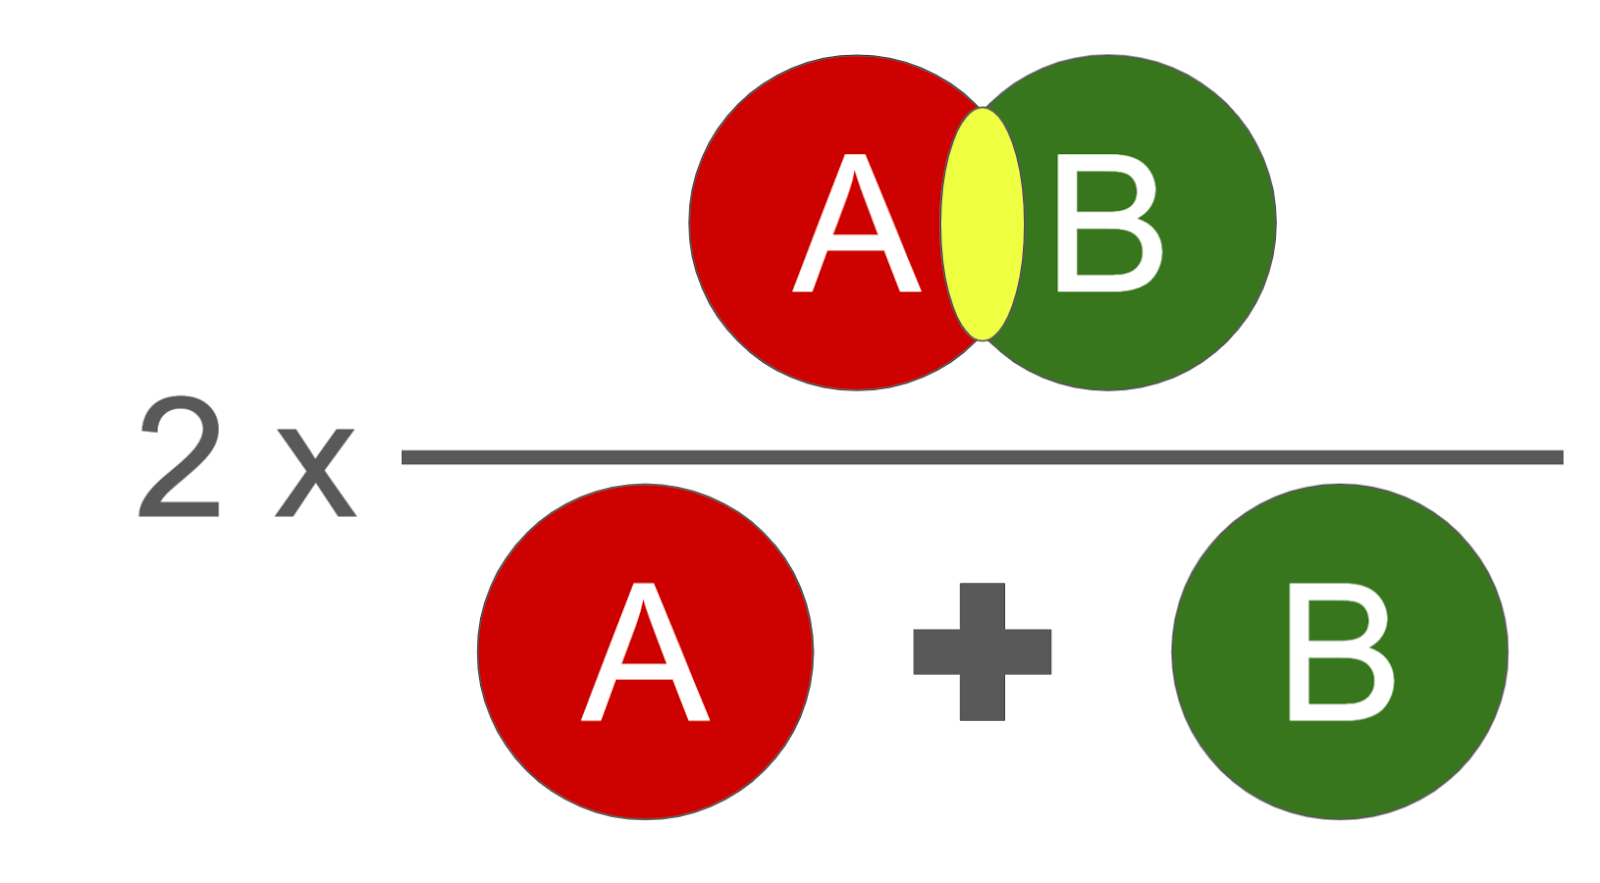

In [ ]:
def dc_loss(pred, target):
    smooth = 1.

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()

    return (1 - ((2. * intersection + smooth) /
              (predf.sum() + targetf.sum() + smooth)))

In [ ]:
# IOU : important to compare loss functions

def iou(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.item()

### U-Net

![alt text](https://www.researchgate.net/publication/331406702/figure/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png)

In [ ]:
#Define the UNet architecture


def conv_layer(input_channels, output_channels):     #This is a helper function to create the convolutional blocks
    conv = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )
    return conv

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_1 = conv_layer(3, 64)
        self.down_2 = conv_layer(64, 128)
        self.down_3 = conv_layer(128, 256)
        self.down_4 = conv_layer(256, 512)
        self.down_5 = conv_layer(512, 1024)

        self.up_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_layer(1024, 512)
        self.up_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_layer(512, 256)
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_layer(256, 128)
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_layer(128, 64)

        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)
        self.output_activation = nn.Sigmoid()

    def forward(self, img):     #The print statements can be used to visualize the input and output sizes for debugging
        x1 = self.down_1(img) #256x256
        #print(x1.size())
        x2 = self.max_pool(x1)
        #print(x2.size())
        x3 = self.down_2(x2)
        #print(x3.size())
        x4 = self.max_pool(x3)
        #print(x4.size())
        x5 = self.down_3(x4)
        #print(x5.size())
        x6 = self.max_pool(x5)
        #print(x6.size())
        x7 = self.down_4(x6)
        #print(x7.size())
        x8 = self.max_pool(x7) #8x8
        #print(x8.size())
        x9 = self.down_5(x8)
        #print(x9.size())

        x = self.up_1(x9) # x.size() = bs, 512, h, w x7.size() = bs, 512, h, w #16x16
        #print(x.size())
        x = self.up_conv_1(torch.cat([x, x7], 1)) # torch.cat([x, x7], 1).size() = bs, 1024, h, w
        #print(x.size())
        x = self.up_2(x)
        #print(x.size())
        x = self.up_conv_2(torch.cat([x, x5], 1))
        #print(x.size())
        x = self.up_3(x)
        #print(x.size())
        x = self.up_conv_3(torch.cat([x, x3], 1))
        #print(x.size())
        x = self.up_4(x)
        #print(x.size())
        x = self.up_conv_4(torch.cat([x, x1], 1)) #256x256
        #print(x.size())

        x = self.output(x)
        x = self.output_activation(x)
        #print(x.size())

        return x


In [ ]:
#Datasets
train_dataset = Dataset(img_files_train, mask_files_train)
test_dataset = Dataset(img_files_test, mask_files_test)

#Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs_test, shuffle=True)

In [ ]:
#Initialize the model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)


writer.add_graph(model, images.to(device)) # We are adding the model to TensorBoard
writer.close()

In [ ]:
#define path where to save the model
PATH = '/content/drive/MyDrive/Colab Notebooks/unet.pth'

In [ ]:
from tqdm import tqdm

#Training function
def train(model, epochs):

    #Keep track of average training and test losses for each epoch
    avg_train_losses = []
    avg_test_losses = []

    #Trigger for earlystopping
    earlystopping = False

    #Training loop
    for epoch in range(epochs):

        #Record the training and test losses for each batch in this epoch
        train_losses = []
        test_losses = []
        IOU_result = []

        model.train()

        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (images, targets) in loop:

            images = images.to(device)
            targets = targets.to(device) # the ground truth mask

            model.zero_grad()
            pred = model(images)
            loss = dc_loss(pred, targets)

            IOU = iou(pred, targets, eps=1e-6) # IOU

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            IOU_result.append(IOU)

            avg_train_loss = np.average(train_losses)
            writer.add_scalar('train_loss', avg_train_loss, epoch) # tensorboard

            avg_IOU_result = np.average(IOU_result)
            writer.add_scalar('IOU', avg_IOU_result, epoch) # tensorboard

            with torch.no_grad():     #Show some samples at the first batch of each epoch
                if batch == 1:
                    torch.save(model.state_dict(), PATH)

                    model.eval()

                    (img, mask) = next(iter(test_dataloader))
                    img = img.to(device)
                    mask = mask.to(device)
                    mask = mask[0]
                    pred = model(img)

                    plt.figure(figsize=(12,12))
                    plt.subplot(1,3,1)
                    plt.imshow(np.squeeze(img.cpu().numpy()[0]).transpose(1,2,0))
                    plt.title('Original Image')
                    plt.subplot(1,3,2)
                    plt.imshow((mask.cpu().numpy()).transpose(1, 2, 0).squeeze(axis=2))
                    #plt.imshow(np.squeeze(mask.cpu().numpy()[0]).transpose(1,2,0))
                    plt.title('Original Mask')
                    plt.subplot(1,3,3)
                    plt.imshow(np.squeeze(pred.cpu()[0]) > .5)
                    plt.title('Prediction')
                    plt.show()
                    model.train()

        model.eval()

        with torch.no_grad():     #Record and print average validation loss for each epoch
            for test_batch, (test_images, test_targets) in enumerate(test_dataloader):
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)
                test_pred = model(test_images.detach())

                test_loss = dc_loss(test_pred, test_targets).item()

                test_losses.append(test_loss)

                avg_test_loss = np.average(test_losses)
                writer.add_scalar('test_loss', avg_test_loss, epoch) # tensorboard

            epoch_avg_train_loss = np.average(train_losses)
            epoch_avg_test_loss = np.average(test_losses)
            avg_train_losses.append(epoch_avg_train_loss)
            avg_test_losses.append(epoch_avg_test_loss)

            print_msg = (f'train_loss: {epoch_avg_train_loss:.5f} ' + f'valid_loss: {epoch_avg_test_loss:.5f}')

            print(print_msg)

        if epoch > 50 :     #Early stopping with a patience of 1 and a minimum of 5 epochs. We will not use it
        # so we can visualise the overfitting of TensorBoard
            if avg_test_losses[-1]>=avg_test_losses[-2]:
                print("Early Stopping Triggered With Patience 1")
                torch.save(model.state_dict(), PATH)
                earlystopping = True
        if earlystopping:
            break

    model.fit(train_dataloader, epochs=epochs, validation_data=test_dataloader, callbacks=[tensorboard_callback])

    writer.close()

    return  model, avg_train_losses, avg_test_losses

In [ ]:
#Train the model
best_model, avg_train_losses, avg_val_losses = train(model, epochs)